In [26]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from termcolor import colored as cl
from math import floor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret.iloc[i] < 0:
            up.append(0)
            down.append(ret.iloc[i])
        else:
            up.append(ret.iloc[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi.iloc[i-1] > 30 and rsi.iloc[i] < 30:
            if signal != 1:
                buy_price.append(prices.iloc[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi.iloc[i-1] < 70 and rsi.iloc[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices.iloc[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal

In [37]:
def get_graphs(ticker_name):
    stock = yf.Ticker(ticker_name)
    hist = stock.history(start='2022-10-01', end='2024-10-01')
    hist['rsi_14'] = get_rsi(hist['Close'], 14)
    hist = hist.dropna()
    hist.tail()

    sp500 = yf.Ticker("SPY")
    spx = sp500.history(period = '2y')
    print(spx['Close'].head())

    ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
    ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
    ax1.plot(hist['Close'], linewidth = 2.5)
    ax1.set_title(ticker_name + ' CLOSE PRICE')
    ax2.plot(hist['rsi_14'], color = 'orange', linewidth = 2.5)
    ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
    ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
    ax2.set_title(ticker_name + ' RELATIVE STRENGTH INDEX')
    plt.show()

    buy_price, sell_price, rsi_signal = implement_rsi_strategy(hist['Close'], hist['rsi_14'])

    ax1 = plt.subplot2grid((15,1), (0,0), rowspan = 4, colspan = 1)
    ax2 = plt.subplot2grid((15,1), (5,0), rowspan = 4, colspan = 1)
    ax1.plot(hist['Close'], linewidth = 2.5, color = 'skyblue', label = 'ibm')
    ax1.plot(hist.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
    ax1.plot(hist.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
    ax1.set_title('RSI Trade Signals For ' + ticker_name)
    ax1.set_ylabel('Price (USD)')
    ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(10, 4)))
    ax2.plot(hist['rsi_14'], color = 'orange', linewidth = 2.5)
    ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
    ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
    ax2.set_ylabel('RSI')
    ax2.set_xlabel('Date')
    ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(10, 4)))
    plt.show()

    position = []
    for i in range(len(rsi_signal)):
        if rsi_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)
            
    for i in range(len(hist['Close'])):
        if rsi_signal[i] == 1:
            position[i] = 1
        elif rsi_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
        
    sp500_position = []
    for i in range(len(hist['Close'])):
        sp500_position.append(1)
            
    rsi = hist['rsi_14']
    close_price = hist['Close']
    rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(hist.index)
    position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(hist.index)

    frames = [close_price, rsi, rsi_signal, position]
    strategy = pd.concat(frames, join = 'inner', axis = 1)

    ret = pd.DataFrame(np.diff(hist['Close'])).rename(columns = {0:'returns'})
    rsi_strategy_ret = []
    ret_percent = [None]

    sp500_ret = pd.DataFrame(np.diff(spx['Close'])).rename(columns = {0:'returns'})

    for i in range(len(ret)):
        returns = ret['returns'][i]*strategy['rsi_position'][i]
        rsi_strategy_ret.append(returns)
        if (i != 0):
            ret_percent.append(returns / hist['Close'][i-1])
        
    rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
    rsi_strategy_ret_df['returns_percent'] = ret_percent
    sp500_number_of_stocks = floor(100000 / spx['Close'][0])
    sp500_total_values = [100000]
    sp500_total_value = 100000
    number_of_stocks2 = floor(100000 / hist['Close'][0])
    total_values2 = [100000]
    total_value2 = 100000
    investment_value = 100000
    rsi_investment_ret = []
    gained_returns = 0
    total_values = [100000]
    total_value = 100000
    for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
        if i != 0 and strategy['rsi_position'][i] == 0 and strategy['rsi_position'][i-1] == 1:
            investment_value += gained_returns
            gained_returns = 0
        number_of_stocks = floor(investment_value/hist['Close'][i])
        returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
        returns2 = number_of_stocks2*ret['returns'][i]
        total_value += returns
        total_value2 += returns2
        if strategy['rsi_position'][i] == 1:
            gained_returns += returns
        rsi_investment_ret.append(returns)
        total_values.append(total_value)
        total_values2.append(total_value2)

        #S&P 500 returns
        sp500_returns = sp500_number_of_stocks*sp500_ret['returns'][i]
        sp500_total_value += sp500_returns
        sp500_total_values.append(sp500_total_value)

    rsi_strategy_ret_df['rsi_returns'].dropna()
    rsi_strategy_ret_df = rsi_strategy_ret_df[rsi_strategy_ret_df['rsi_returns'] != 0]

    dates = hist.index

    if len(dates) > len(total_values):
        dates = dates[:len(total_values)]

    plt.figure(figsize=(10, 6))
    plt.plot(dates, total_values, linewidth=2.5, color='green', label='RSI strategy')
    plt.plot(dates, sp500_total_values, linewidth=2.5, color='orange', linestyle='--', label='S&P 500 investment')
    plt.plot(dates, total_values2, linewidth=2.5, color='purple', label='No trading strategy')
    plt.title('Total Value Of Investment in ' + ticker_name + ' Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Portfolio Value (USD)', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(rsi_strategy_ret_df['returns_percent'], bins=40, color='green', edgecolor = 'white', alpha=0.7)
    plt.title('Return Distribution Histogram')
    plt.xlabel('Percent Returns')
    plt.ylabel('Frequency')
    plt.show()

Date
2022-12-02 00:00:00-05:00    395.258698
2022-12-05 00:00:00-05:00    388.148285
2022-12-06 00:00:00-05:00    382.553223
2022-12-07 00:00:00-05:00    381.902435
2022-12-08 00:00:00-05:00    384.894165
Name: Close, dtype: float64


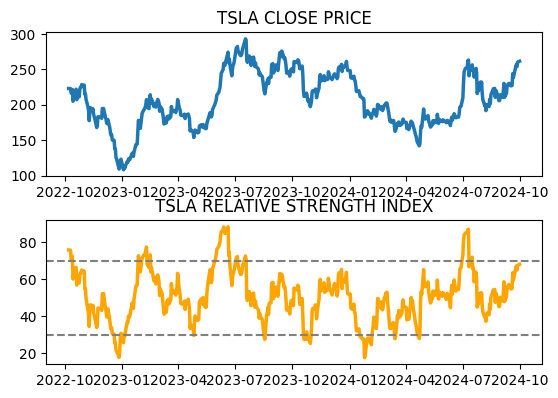

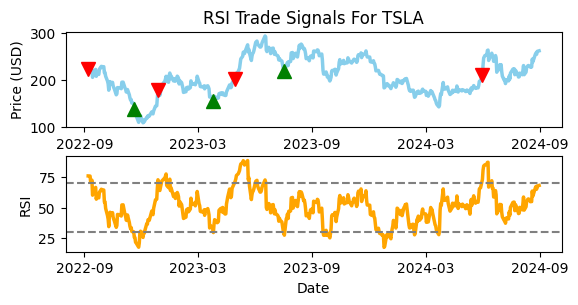

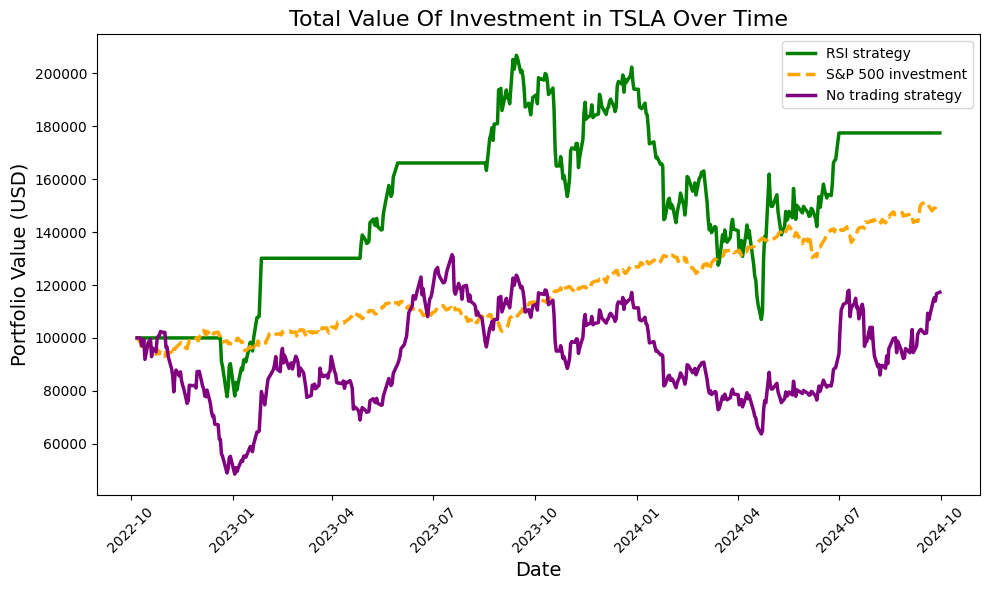

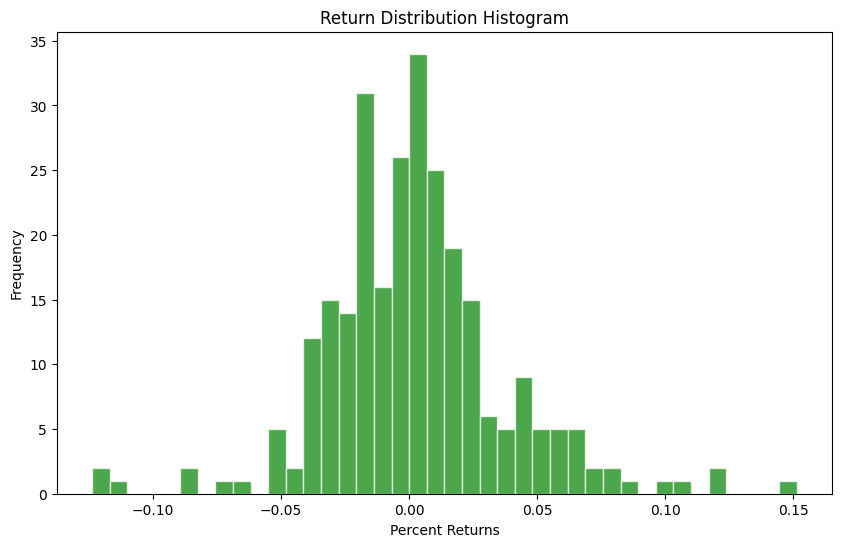

In [38]:
get_graphs('TSLA')